In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn
# !{sys.executable} -m pip install --upgrade gensim
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install beautifulsoup4
# import nltk
# nltk.download('punkt')

In [326]:
import os
import re
import gensim
import multiprocessing
import random
import logging
import numpy as np
import zipfile
import pickle

import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from urllib import request

from pathlib import Path
from os import listdir
from os.path import isfile, join
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup

from sklearn.cluster import KMeans
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
SKIP_FILES = ""
NEWLINE = '\n'

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r",", " ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

"""
read training files
"""
def read_files(path):
    print("path: {}...".format(path))
    for root, dirnames, filenames in os.walk(path):
        for dirname in dirnames:
            read_files(os.path.join(root, dirname))
        for filename in filenames:
            if filename not in SKIP_FILES:
                filepath = os.path.join(root, filename)
                if os.path.isfile(filepath):
                    lines = []
                    f = open(filepath, encoding='latin-1')
                    for line in f:
                        lines.append(line)
                    f.close()
                    content = NEWLINE.join(lines)
                    yield filename, content

def download(url, filename):
    """Download a file if not present"""
    if not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

    return data_path

In [4]:
def get_data(url, filename):
    data_path = download(url, filename)
    documents = []
    print("building documents...")
    for fname, text in read_files(data_path):
        documents.append(clean_str(text).split(' '))
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]
    print("building documents done")
    return documents

##### Download Data Training

In [5]:
documents = get_data(url='https://github.com/kadriansyah/notebook/raw/master/alodokter-doc2vec-article/', filename="data.zip")
print("we have {} documents".format(len(documents)))

building documents...
path: data...
building documents done
we have 7932 documents


In [6]:
documents[0]

TaggedDocument(words=['penyebab', 'bayi', 'muntah', 'setelah', 'minum', 'asi', 'dan', 'cara', 'mengatasinya', 'bayi', 'muntah', 'setelah', 'minum', 'asi', '(', 'air', 'susu', 'ibu', ')', 'adalah', 'keluhan', 'yang', 'sering', 'terjadi', 'sebagian', 'bayi', 'bahkan', 'mengalaminya', 'hampir', 'setiap', 'kali', 'selesai', 'menyusu', 'meski', 'umumnya', 'normal', 'kondisi', 'ini', 'bisa', 'juga', 'disebabkan', 'oleh', 'gangguan', 'berbahaya', 'yang', 'harus', 'diwaspadai', 'bayi', 'muntah', 'setelah', 'minum', 'asi', 'dikenal', 'dengan', 'istilah', 'gumoh', 'gumoh', 'dikatakan', 'normal', 'apabila', 'tidak', 'menyebabkan', 'bayi', 'rewel', 'atau', 'sesak', 'napas', 'meskipun', 'dapat', 'dicegah', 'kondisi', 'tersebut', 'tidak', 'memerlukan', 'penanganan', 'khusus', 'dan', 'normal', 'terjadi', 'penyebab', 'bayi', 'muntah', 'setelah', 'minum', 'asi', 'gumoh', 'disebabkan', 'oleh', 'asi', 'atau', 'susu', 'yang', 'ditelan', 'bayi', 'kembali', 'ke', 'kerongkongan', 'karena', 'otot', 'di', 'sal

In [418]:
def evaluate(model, documents, steps):
    percentiles = np.zeros(steps)
    for step in range(steps):
        docid = np.random.randint(model.docvecs.count)
        inferred_vector = model.infer_vector(documents[docid][0])
        similars = model.docvecs.most_similar(positive=[inferred_vector], topn=10)
        for idx,simdoc in enumerate(similars):
            if simdoc[0] == docid:
                print("found similar document with id {} in position {} with similarity score {}".format(simdoc[0], idx, simdoc[1]))
                percentiles[step] = ((len(similars) - idx) / len(similars)) * 100
                break
    return np.mean(percentiles)

def train(documents=documents, model_name="model/alodokter-articles-doc2vec.model", max_epochs=50, patience=3):
    best_mean_percentiles = 0
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = Doc2Vec(dm=1, vector_size=100, window=2, alpha=0.1, min_alpha=0.0001, min_count=5, epochs=1, workers=5)
    model.build_vocab(documents)
    for epoch in range(max_epochs):
        print('training epoch {:d} ...'.format(epoch))
        model.train(documents, total_examples=model.corpus_count,epochs=model.epochs)
        mean_percentiles = evaluate(model,documents,10)
        print('mean percentiles: {:.2f}'.format(mean_percentiles))
        
        if mean_percentiles < best_mean_percentiles:
            print("current mean_percentiles: {:.2f}, best: {:.2f}".format(mean_percentiles, best_mean_percentiles))
            patience = patience-1
        else:
            best_mean_percentiles = mean_percentiles
            print("========== Saving best model with mean_percentiles: {:.2f} ==========".format(mean_percentiles))
            model.save(model_name)
            patience = patience+1
        
        if patience == 0:
            print("early stop...")
            print("========== Saving best model with mean_percentiles: {:.2f} ==========".format(best_mean_percentiles))
            break
    
    return model

##### Document to Vector Training

In [419]:
training = True
if training:
    model = train(documents)
else:
    print('loading documents...')
    model = Doc2Vec.load('model/alodokter-articles-doc2vec.model')
    print('loading documents done')

# prepare vectors for training
trained_vectors = [model.docvecs[i] for i in range(len(model.docvecs))]

2020-02-24 16:39:47,049 : INFO : collecting all words and their counts
2020-02-24 16:39:47,050 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-02-24 16:39:47,725 : INFO : collected 54008 word types and 7932 unique tags from a corpus of 7932 examples and 4866436 words
2020-02-24 16:39:47,725 : INFO : Loading a fresh vocabulary
2020-02-24 16:39:47,758 : INFO : effective_min_count=5 retains 15409 unique words (28% of original 54008, drops 38599)
2020-02-24 16:39:47,759 : INFO : effective_min_count=5 leaves 4811064 word corpus (98% of original 4866436, drops 55372)
2020-02-24 16:39:47,802 : INFO : deleting the raw counts dictionary of 54008 items
2020-02-24 16:39:47,803 : INFO : sample=0.001 downsamples 51 most-common words
2020-02-24 16:39:47,804 : INFO : downsampling leaves estimated 4105293 word corpus (85.3% of prior 4811064)
2020-02-24 16:39:47,845 : INFO : estimated required memory for 15409 words and 100 dimensions: 23204500 bytes
2020-02-24 16:3

training epoch 0 ...


2020-02-24 16:39:52,480 : INFO : EPOCH 1 - PROGRESS: at 44.29% examples, 1819889 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:39:53,480 : INFO : EPOCH 1 - PROGRESS: at 91.81% examples, 1887371 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:39:53,664 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-24 16:39:53,666 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-24 16:39:53,667 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-24 16:39:53,671 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-24 16:39:53,674 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-02-24 16:39:53,675 : INFO : EPOCH - 1 : training on 4866436 raw words (4113098 effective words) took 2.2s, 1871649 effective words/s
2020-02-24 16:39:53,675 : INFO : training on a 4866436 raw words (4113098 effective words) took 2.2s, 1869455 effective words/s
2020-02-24 16:39:53,676 : INFO : precomputing L2-no

found similar document with id 6758 in position 0 with similarity score 0.6581401824951172
found similar document with id 6885 in position 0 with similarity score 0.7841606140136719
found similar document with id 6263 in position 0 with similarity score 0.7363199591636658
found similar document with id 6302 in position 0 with similarity score 0.6312214732170105
found similar document with id 6542 in position 0 with similarity score 0.7588212490081787
found similar document with id 260 in position 1 with similarity score 0.5602511763572693
found similar document with id 1522 in position 0 with similarity score 0.5990457534790039
found similar document with id 1698 in position 0 with similarity score 0.6986172199249268
found similar document with id 7219 in position 0 with similarity score 0.7189825773239136
mean percentiles: 89.00
========== Saving best model with mean_percentiles: 89.00 ==========


2020-02-24 16:39:53,918 : INFO : saved model/alodokter-articles-doc2vec.model
2020-02-24 16:39:53,919 : WARNING : Effective 'alpha' higher than previous training cycles
2020-02-24 16:39:53,920 : INFO : training model with 5 workers on 15409 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=2


training epoch 1 ...


2020-02-24 16:39:54,927 : INFO : EPOCH 1 - PROGRESS: at 44.94% examples, 1844047 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:39:55,932 : INFO : EPOCH 1 - PROGRESS: at 74.47% examples, 1525728 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:39:56,586 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-24 16:39:56,590 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-24 16:39:56,591 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-24 16:39:56,592 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-24 16:39:56,593 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-02-24 16:39:56,593 : INFO : EPOCH - 1 : training on 4866436 raw words (4113180 effective words) took 2.7s, 1540646 effective words/s
2020-02-24 16:39:56,594 : INFO : training on a 4866436 raw words (4113180 effective words) took 2.7s, 1538402 effective words/s
2020-02-24 16:39:56,624 : WARNING : Effective 'alph

found similar document with id 1580 in position 0 with similarity score 0.6528360843658447
found similar document with id 4149 in position 0 with similarity score 0.770876407623291
found similar document with id 1557 in position 0 with similarity score 0.7287918925285339
found similar document with id 6726 in position 0 with similarity score 0.6671602725982666
found similar document with id 3271 in position 0 with similarity score 0.6129780411720276
found similar document with id 6795 in position 2 with similarity score 0.643851637840271
found similar document with id 7188 in position 0 with similarity score 0.8533931970596313
found similar document with id 6246 in position 0 with similarity score 0.7743846774101257
found similar document with id 5177 in position 0 with similarity score 0.7675994634628296
mean percentiles: 88.00
current mean_percentiles: 88.00, best: 89.00
training epoch 2 ...


2020-02-24 16:39:57,632 : INFO : EPOCH 1 - PROGRESS: at 38.87% examples, 1600002 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:39:58,637 : INFO : EPOCH 1 - PROGRESS: at 70.35% examples, 1444493 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:39:59,634 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-24 16:39:59,635 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-24 16:39:59,636 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-24 16:39:59,640 : INFO : EPOCH 1 - PROGRESS: at 99.77% examples, 1363819 words/s, in_qsize 1, out_qsize 1
2020-02-24 16:39:59,641 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-24 16:39:59,642 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-02-24 16:39:59,643 : INFO : EPOCH - 1 : training on 4866436 raw words (4114037 effective words) took 3.0s, 1365254 effective words/s
2020-02-24 16:39:59,643 : INFO : training on a 4866436 raw words 

found similar document with id 5175 in position 0 with similarity score 0.7192103862762451
found similar document with id 908 in position 0 with similarity score 0.6966367959976196
found similar document with id 1686 in position 0 with similarity score 0.6787267923355103
found similar document with id 3894 in position 0 with similarity score 0.697080135345459
found similar document with id 3565 in position 0 with similarity score 0.7586582899093628
found similar document with id 4150 in position 0 with similarity score 0.6618915796279907
found similar document with id 526 in position 0 with similarity score 0.6181932687759399
found similar document with id 1182 in position 0 with similarity score 0.6067416667938232
found similar document with id 1567 in position 0 with similarity score 0.6190108060836792
mean percentiles: 90.00
========== Saving best model with mean_percentiles: 90.00 ==========
training epoch 3 ...


2020-02-24 16:40:00,836 : INFO : EPOCH 1 - PROGRESS: at 28.29% examples, 1154885 words/s, in_qsize 10, out_qsize 0
2020-02-24 16:40:01,838 : INFO : EPOCH 1 - PROGRESS: at 62.53% examples, 1283227 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:40:02,844 : INFO : EPOCH 1 - PROGRESS: at 97.39% examples, 1331261 words/s, in_qsize 10, out_qsize 0
2020-02-24 16:40:02,910 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-24 16:40:02,914 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-24 16:40:02,916 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-24 16:40:02,917 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-24 16:40:02,918 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-02-24 16:40:02,919 : INFO : EPOCH - 1 : training on 4866436 raw words (4112810 effective words) took 3.1s, 1332041 effective words/s
2020-02-24 16:40:02,919 : INFO : training on a 4866436 raw word

found similar document with id 1723 in position 5 with similarity score 0.5359184741973877
found similar document with id 7002 in position 0 with similarity score 0.7046673893928528
found similar document with id 3930 in position 0 with similarity score 0.690201461315155
found similar document with id 6778 in position 0 with similarity score 0.6639808416366577
found similar document with id 5111 in position 0 with similarity score 0.6725974082946777
found similar document with id 1814 in position 0 with similarity score 0.681733250617981
found similar document with id 3331 in position 0 with similarity score 0.6709105372428894
found similar document with id 716 in position 9 with similarity score 0.46308082342147827
found similar document with id 4016 in position 0 with similarity score 0.7006474137306213
found similar document with id 7004 in position 0 with similarity score 0.7070361971855164
mean percentiles: 86.00
current mean_percentiles: 86.00, best: 90.00
training epoch 4 ...


2020-02-24 16:40:03,961 : INFO : EPOCH 1 - PROGRESS: at 41.98% examples, 1716000 words/s, in_qsize 10, out_qsize 0
2020-02-24 16:40:04,965 : INFO : EPOCH 1 - PROGRESS: at 72.44% examples, 1482706 words/s, in_qsize 10, out_qsize 0
2020-02-24 16:40:05,943 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-24 16:40:05,948 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-24 16:40:05,950 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-24 16:40:05,952 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-24 16:40:05,954 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-02-24 16:40:05,954 : INFO : EPOCH - 1 : training on 4866436 raw words (4113029 effective words) took 3.0s, 1370938 effective words/s
2020-02-24 16:40:05,955 : INFO : training on a 4866436 raw words (4113029 effective words) took 3.0s, 1369258 effective words/s
2020-02-24 16:40:05,982 : INFO : saving Doc2Vec o

found similar document with id 5414 in position 0 with similarity score 0.695095956325531
found similar document with id 6661 in position 0 with similarity score 0.7759463787078857
found similar document with id 7176 in position 0 with similarity score 0.7223647832870483
found similar document with id 1408 in position 1 with similarity score 0.5447152256965637
found similar document with id 5853 in position 0 with similarity score 0.6558766961097717
found similar document with id 4074 in position 0 with similarity score 0.758490800857544
found similar document with id 5563 in position 0 with similarity score 0.7000430226325989
found similar document with id 6917 in position 0 with similarity score 0.667576014995575
found similar document with id 4585 in position 0 with similarity score 0.7887220978736877
found similar document with id 6304 in position 0 with similarity score 0.7100865840911865
mean percentiles: 99.00
========== Saving best model with mean_percentiles: 99.00 ==========


2020-02-24 16:40:07,173 : INFO : EPOCH 1 - PROGRESS: at 28.29% examples, 1147280 words/s, in_qsize 10, out_qsize 0
2020-02-24 16:40:08,174 : INFO : EPOCH 1 - PROGRESS: at 52.55% examples, 1076818 words/s, in_qsize 10, out_qsize 0
2020-02-24 16:40:09,193 : INFO : EPOCH 1 - PROGRESS: at 77.87% examples, 1056645 words/s, in_qsize 10, out_qsize 0
2020-02-24 16:40:09,960 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-24 16:40:09,963 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-24 16:40:09,966 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-24 16:40:09,967 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-24 16:40:09,971 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-02-24 16:40:09,972 : INFO : EPOCH - 1 : training on 4866436 raw words (4112641 effective words) took 3.8s, 1079429 effective words/s
2020-02-24 16:40:09,972 : INFO : training on a 4866436 raw wor

found similar document with id 2392 in position 0 with similarity score 0.7150622606277466
found similar document with id 5756 in position 0 with similarity score 0.7310726642608643
found similar document with id 3500 in position 0 with similarity score 0.6883403062820435
found similar document with id 3794 in position 0 with similarity score 0.7262363433837891
found similar document with id 2290 in position 0 with similarity score 0.7105275988578796
found similar document with id 5828 in position 0 with similarity score 0.7200591564178467
found similar document with id 1785 in position 0 with similarity score 0.6067046523094177
found similar document with id 3638 in position 0 with similarity score 0.6827194690704346
found similar document with id 2219 in position 2 with similarity score 0.6306583881378174
mean percentiles: 88.00
current mean_percentiles: 88.00, best: 99.00
training epoch 6 ...


2020-02-24 16:40:11,002 : INFO : EPOCH 1 - PROGRESS: at 39.51% examples, 1627981 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:40:12,009 : INFO : EPOCH 1 - PROGRESS: at 81.42% examples, 1668361 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:40:12,672 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-24 16:40:12,677 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-24 16:40:12,680 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-24 16:40:12,682 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-24 16:40:12,688 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-02-24 16:40:12,689 : INFO : EPOCH - 1 : training on 4866436 raw words (4114282 effective words) took 2.7s, 1530887 effective words/s
2020-02-24 16:40:12,689 : INFO : training on a 4866436 raw words (4114282 effective words) took 2.7s, 1528303 effective words/s
2020-02-24 16:40:12,715 : WARNING : Effective 'alph

found similar document with id 2039 in position 0 with similarity score 0.7164029479026794
found similar document with id 2549 in position 0 with similarity score 0.6566582322120667
found similar document with id 1712 in position 0 with similarity score 0.7590450048446655
found similar document with id 1561 in position 0 with similarity score 0.6637897491455078
found similar document with id 653 in position 1 with similarity score 0.6633888483047485
found similar document with id 7318 in position 0 with similarity score 0.7998452186584473
found similar document with id 3030 in position 0 with similarity score 0.7047588229179382
found similar document with id 4156 in position 0 with similarity score 0.7750661373138428
mean percentiles: 79.00
current mean_percentiles: 79.00, best: 99.00
training epoch 7 ...


2020-02-24 16:40:13,735 : INFO : EPOCH 1 - PROGRESS: at 29.40% examples, 1193532 words/s, in_qsize 10, out_qsize 1
2020-02-24 16:40:14,736 : INFO : EPOCH 1 - PROGRESS: at 69.77% examples, 1427339 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:40:15,385 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-24 16:40:15,386 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-24 16:40:15,387 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-24 16:40:15,389 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-24 16:40:15,393 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-02-24 16:40:15,393 : INFO : EPOCH - 1 : training on 4866436 raw words (4112648 effective words) took 2.7s, 1539464 effective words/s
2020-02-24 16:40:15,394 : INFO : training on a 4866436 raw words (4112648 effective words) took 2.7s, 1536825 effective words/s
2020-02-24 16:40:15,410 : WARNING : Effective 'alp

found similar document with id 2876 in position 0 with similarity score 0.6885907053947449
found similar document with id 2155 in position 0 with similarity score 0.7729560136795044
found similar document with id 6055 in position 0 with similarity score 0.7520697116851807
found similar document with id 6523 in position 0 with similarity score 0.7506000995635986
found similar document with id 5070 in position 0 with similarity score 0.7934790849685669
found similar document with id 4368 in position 0 with similarity score 0.6804259419441223
found similar document with id 2052 in position 0 with similarity score 0.6985034942626953
found similar document with id 6912 in position 0 with similarity score 0.7058160305023193
found similar document with id 6220 in position 0 with similarity score 0.7168246507644653
mean percentiles: 90.00
current mean_percentiles: 90.00, best: 99.00
training epoch 8 ...


2020-02-24 16:40:16,423 : INFO : EPOCH 1 - PROGRESS: at 38.91% examples, 1590989 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:40:17,426 : INFO : EPOCH 1 - PROGRESS: at 84.51% examples, 1729409 words/s, in_qsize 9, out_qsize 0
2020-02-24 16:40:17,724 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-24 16:40:17,725 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-24 16:40:17,725 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-24 16:40:17,729 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-24 16:40:17,731 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-02-24 16:40:17,731 : INFO : EPOCH - 1 : training on 4866436 raw words (4113596 effective words) took 2.3s, 1775109 effective words/s
2020-02-24 16:40:17,732 : INFO : training on a 4866436 raw words (4113596 effective words) took 2.3s, 1772620 effective words/s


found similar document with id 3372 in position 8 with similarity score 0.5536086559295654
found similar document with id 5383 in position 0 with similarity score 0.6990315914154053
found similar document with id 6078 in position 0 with similarity score 0.8071112632751465
found similar document with id 4722 in position 0 with similarity score 0.7539226412773132
found similar document with id 557 in position 5 with similarity score 0.5683082342147827
found similar document with id 7243 in position 0 with similarity score 0.6897519826889038
found similar document with id 3418 in position 0 with similarity score 0.6509588956832886
found similar document with id 1950 in position 0 with similarity score 0.5101697444915771
found similar document with id 3680 in position 0 with similarity score 0.7661495208740234
found similar document with id 3602 in position 0 with similarity score 0.7242410778999329
mean percentiles: 87.00
current mean_percentiles: 87.00, best: 99.00
early stop...
========

##### The Silhouette Method
##### reference: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means

In [136]:
from sklearn.metrics import silhouette_score

silhouette_scores  = []
kmax = 100

"""
dissimilarity would not be defined for a single cluster, thus minimum number of clusters should be 2
"""
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters=k).fit(trained_vectors)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(trained_vectors, labels, metric='euclidean'))

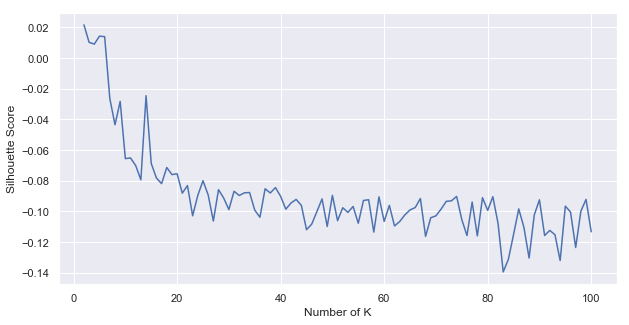

In [137]:
# Silhouette Score Result
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel("Number of K")
plt.ylabel("Silhouette Score")

x = [k for k in range(2, kmax + 1)]
y = silhouette_scores
plt.plot(x,y)

##### KMeans Clustering

In [420]:
training = True
if training:
    n_clusters = 16
    trained_vectors = [model.docvecs[i] for i in range(len(model.docvecs))]
    print('clustering...')
    kmeans = KMeans(n_clusters=n_clusters).fit(trained_vectors)
    clusters = kmeans.labels_.tolist()

    # save the model
    pickle.dump(kmeans, open('model/kmeans.pkl','wb'))
    print('clustering done')
else:
    print('load model...')
    kmeans = pickle.load(open('model/kmeans.pkl', 'rb'))
    print('load model done')

clustering...
clustering done


In [456]:
# create dictionary doc-id to cluster-id
docs_clusters = {(idx, cluster) for idx, cluster in enumerate(clusters)}

clusters_docs = {}
for item in docs_clusters:
    if item[1] in clusters_docs.keys():
        clusters_docs[item[1]].append(item[0])
    else:
        clusters_docs[item[1]] = []
        clusters_docs[item[1]].append(item[0])

##### Draw Cluster Diagram

In [422]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)

def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

In [423]:
centroids = kmeans.cluster_centers_

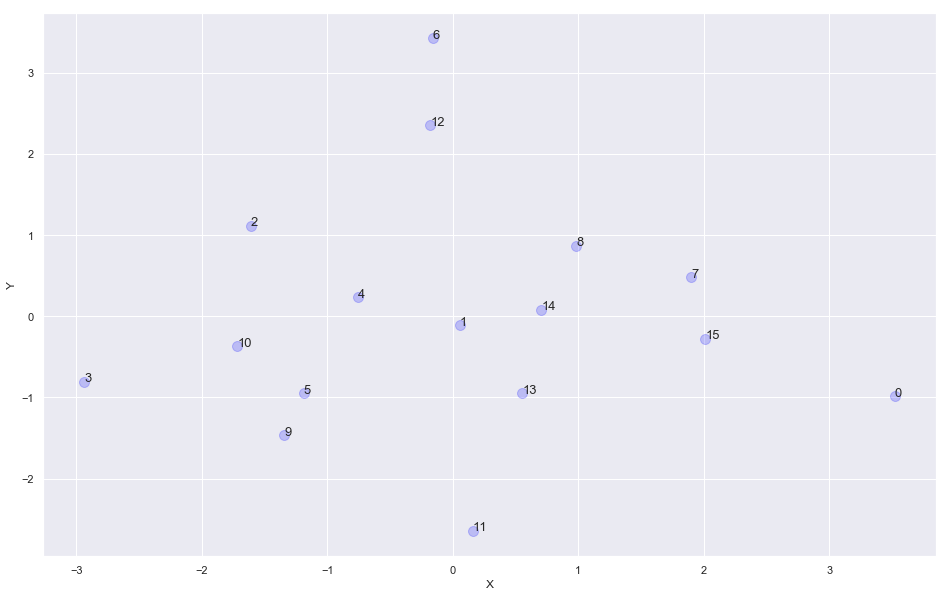

In [487]:
pca_result = PCA(n_components=2).fit_transform(centroids)
ax = plt.figure(figsize=(16,10)).gca()
ax.scatter(
    x=pca_result[:,0],
    y=pca_result[:,1],
    c='blue',
    s=100,
    alpha=0.2,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
for i in range(0, n_clusters):
    ax.annotate(str(i), (pca_result[i:i+1,0], pca_result[i:i+1,1]), fontsize=13)

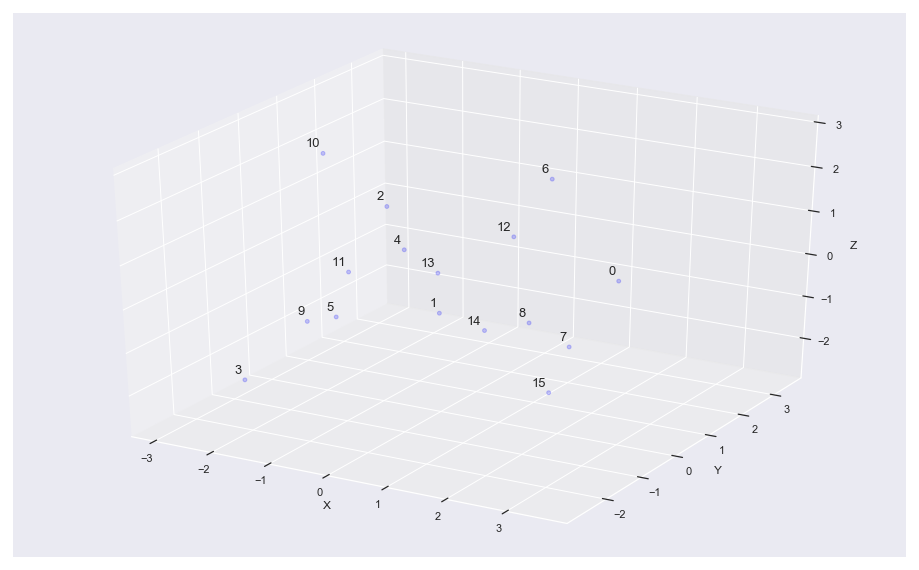

In [486]:
pca_result = PCA(n_components=3).fit_transform(centroids)
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0],
    ys=pca_result[:,1],
    zs=pca_result[:,2],
    c='blue',
    s=15,
    alpha=0.2,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

xyzn = zip(pca_result[:,0], pca_result[:,1], pca_result[:,2])
# add vertices annotation.
for j, xyz_ in enumerate(xyzn): 
    annotate3D(ax, s=str(j), xyz=xyz_, fontsize=13, xytext=(-3,3), textcoords='offset points', ha='right', va='bottom')

##### Draw Documents Cluster

Text(0,0.5,'Y')

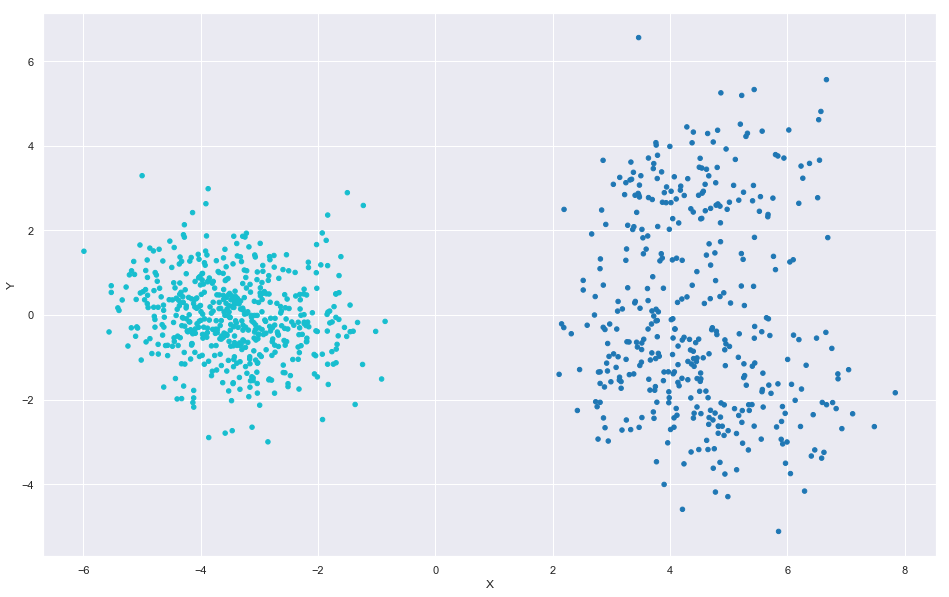

In [484]:
cluster_A = 0
cluster_B = 3
X = [model.docvecs[i] for i in clusters_docs[cluster_A]] + [model.docvecs[i] for i in clusters_docs[cluster_B]]

Y = kmeans.predict(X)
pca_result = PCA(n_components=2).fit_transform(X)

ax = plt.figure(figsize=(16,10)).gca()
ax.scatter(
    x=pca_result[:,0],
    y=pca_result[:,1],
    c=Y,
    s=20,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')

Text(0.5,0,'Z')

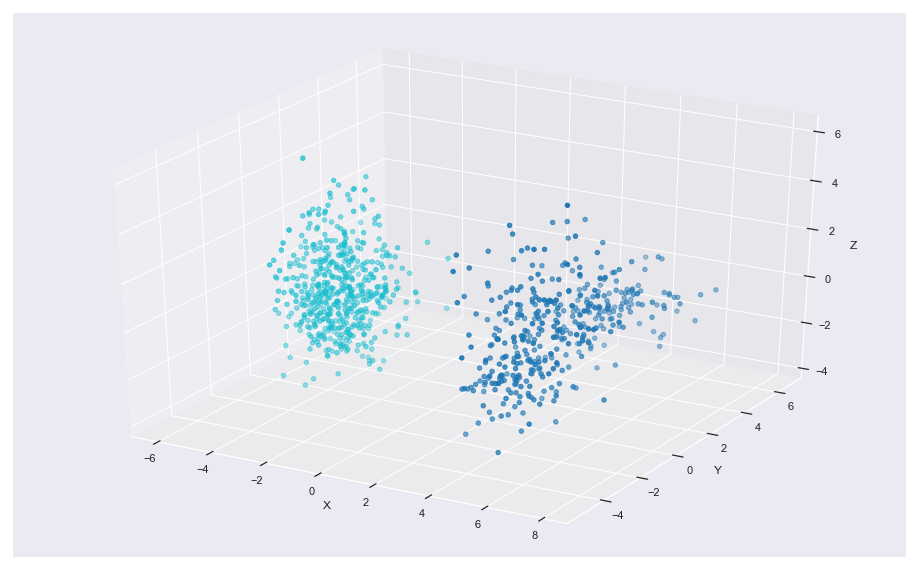

In [485]:
Y = kmeans.predict(X)
pca_result = PCA(n_components=3).fit_transform(X)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0],
    ys=pca_result[:,1],
    zs=pca_result[:,2],
    c=Y,
    s=20,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')